Sean McNulty
Eduard Shokur
Courtney Duzet
Margaret Epstein
Anthony Marcozzi

# Lobsters Logistic Redux
Let's return to the lobster problem, but this I'd like you to use logistic regression to find the solution.  First, the data:

In [36]:
data

array([[-1.95598033,  0.        ],
       [-1.95598033,  0.        ],
       [-1.95598033,  0.        ],
       [-1.95598033,  0.        ],
       [-1.95598033,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  0.        ],
       [-1.51484434,  1.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,  0.        ],
       [-1.07370835,

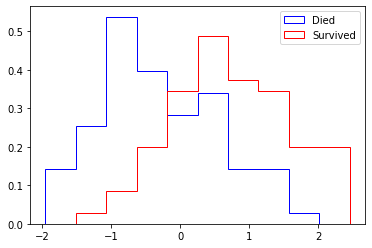

In [37]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt('datasets/lobster_survive.dat',skiprows=1)
X,Y = data.T
X -= X.mean()
X /= X.std()

bins = np.unique(X)
plt.hist(X[Y==0],bins,histtype='step',density=True,label='Died',color='blue')
plt.hist(X[Y==1],bins,histtype='step',density=True,label='Survived',color='red')
plt.legend()
plt.show()

We would still like to know
$$
P(\text{Survive}=1|\text{Length}=x),
$$
where $\text{Survive}$ is a variable indicating whether the lobster survived or not, and $\text{Length}$ is the length of the lobster ($x\in\mathcal{R}$).  

In logistic regression, we will approach this directly by implementing logistic regression, where we model
$$
P(\text{Survive}=1|\text{Length}=x) = \sigma(\Phi \mathbf{w}).
$$
First implement the logistic function
$$
\sigma(z) = \frac{1}{1 + \mathrm{exp}(-z)}
$$

In [38]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

Next, define the log-posterior function
$$
\mathcal{L}(\mathbf{w};\mathbf{X}_{obs},\mathbf{Y}_{obs}) = \sum_{i=1}^m Y_{obs,i} \ln \sigma(\Phi_i \mathbf{w}) + (1-Y_{obs,i}) \ln (1-\sigma(\Phi_i \mathbf{w})) -\lambda \mathbf{w}^T \mathbf{w} 
$$

In [39]:
#reuse Phi
def Phi(X, d=1):
    return_phi = np.ones((len(X),d+1))
    for i in range(1,d+1):
        return_phi[:,i] = np.power(X,i)
    return return_phi

#define L function
def L(w,X,Y,lamda=0):
    #sum term
    phi = Phi(X)
    sum_total = 0
    for i in range(len(X)):
        first_term = Y[i]*np.log(sigmoid(phi[i,:]@w))
        second_term = (1-Y[i])*np.log(1-sigmoid(phi[i,:]@w))
        third_term = lamda * np.transpose(w)@w
        sum_total += first_term + second_term - third_term 
    return sum_total

We currently lack the tools necessary to minimize this function elegantly, but we can attack it using brute force.  Make the assumption that 
$$
Y_i = w_0 + w_1 X_{obs,i}.
$$
Using either a grid-search approach (check out numpy.meshgrid) or a random sampling approach, search for the values of $\mathbf{w}$ that maximizes this likelihood function.  Plot all computed values of $\mathcal{L}(\mathbf{w})$ as a function of $\mathbf{w}$.  Useful commands for this plotting if you take the grid search approach might be plt.contourf.  For the random sampling approach, you might try plt.scatter (using the c= keyword argument).


In [40]:
#Use a good guess (between 0 and 2 for w1 and -1 and 1 for w0) and do a grid search for the maximum
num = 25
L_array = np.ones((25,25))
w0_vec = np.linspace(-1,1,num)
w1_vec = np.linspace(0,2,num)

for i in range(w0_vec.size):
    for j in range(w1_vec.size):
        L_array[i,j] = L([w0_vec[i],w1_vec[j]],X,Y)

In [41]:
#get indicies where the log-likelihood is maximized
result = np.where(L_array == np.amax(L_array))
indices = result[0][0],result[1][0]

In [42]:
#figure out arrays for the lobster survival
w0 = w0_vec[indices[0]]
w1 = w1_vec[indices[1]]

x = np.linspace(np.amin(X),np.amax(X),100)
y = x.copy()

for i in range(len(x)):
    y[i] = sigmoid(w1 * x[i] + w0)

Using this best parameter set, plot lobster survival as a function of length.

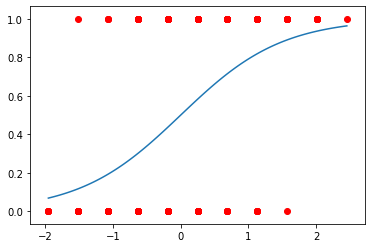

In [43]:
#! Plot lobster survival 
plt.plot(x,y)
plt.scatter(X,Y,c='r')
plt.show()

As a final bonus round, check out the matplotlib function plt.quiver, which is a useful command for plotting gradients (in 2D).  The gradient of the log-posterior function is 
$$
\nabla_\mathbf{w} \mathcal{L} = \sum_{i=1}^m \left[ (\mathbf{Y}_{obs,i} - \sigma(\Phi_i \mathbf{w})) \Phi_i\right] - \lambda\mathbf{w}^T. 
$$
Use the quiver command to produce a plot visualizing the gradient of the log-posterior.  Given this information, can you determine a more efficient way than brute force to find the maximum value of $\mathcal{L}(\mathbf{w}$?

In [44]:
#! use plt.quiver to visualize the gradients of the log-posterior.
phi = Phi(X)

def L_grad_func(Y,w,lamda=0):
    m = len(Y)
    return_sum = 0
    for i in range(m):
        return_sum += (Y[i] - sigmoid(phi[i,:]@w))*phi[i,:]
    return return_sum-lamda*np.transpose(w)

L_grad = np.ones((25,25,2))

for i in range(w0_vec.size):
    for j in range(w1_vec.size):
        L_grad[i,j,:] = L_grad_func(Y,[w0_vec[i],w1_vec[i]])

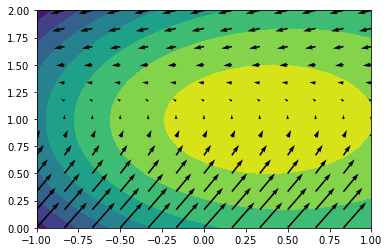

In [45]:
plt.contourf(w0_vec,w1_vec,L_array)
plt.quiver(w0_vec[::2],w1_vec[::2],L_grad[::2,::2,0],L_grad[::2,::2,1])